# User Data Analyses

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from textwrap import wrap
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportions_ztest

import util_func as uf

sns.set_style("whitegrid")
palette = ["#84c3b7", "#7da6c6", "#eaaa60", "#e56b6f", "#c5c5c5"]

dicts = json.load(open("../data/dictionary.json"))
df = pd.read_csv("../data/user_anonymized.csv")

demo_vars, personality_vars, social_vars = (
    dicts["demo_vars"],
    dicts["personality_vars"],
    dicts["social_vars"],
)

other_cats = dicts["other_cats"]
for aspect in ["work", "marital_status", "ethnicity"]:
    df[aspect] = df[aspect].apply(
        lambda x: x.lower() if x.lower() in other_cats[aspect] else "other"
    )

tasks, agents = dicts["tasks"], dicts["agents"]

df["Group"] = df["task_group"] + "_" + df["agent_group"]
df["task_group"] = pd.Categorical(df["task_group"], tasks)
df["agent_group"] = pd.Categorical(df["agent_group"], agents)
df.sort_values(["task_group", "agent_group"], inplace=True)

### Demographics

In [2]:
df.groupby(["task_group", "agent_group"], observed=True)["ethnicity"].value_counts()

# Get value count and percentage for all groups
def get_value_counts(df, groupby_cols, value_col):
    counts = df.groupby(groupby_cols)[value_col].value_counts().unstack(fill_value=0)
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100
    return counts, percentages

ethnicity_counts, ethnicity_percentages = get_value_counts(df, ["task_group", "agent_group"], "ethnicity")
# print(tabulate(ethnicity_counts, headers="keys", tablefmt="psql"))
# print(tabulate(ethnicity_percentages, headers="keys", tablefmt="psql"))

# Combine counts and percentages into a single DataFrame
def combine_counts_and_percentages(counts, percentages):
    combined = counts.copy()
    for col in percentages.columns:
        combined[col] = combined[col].astype(str) + " (" + percentages[col].round(1).astype(str) + "\%)"
    return combined

combined_ethnicity = combine_counts_and_percentages(ethnicity_counts, ethnicity_percentages)
# print(tabulate(combined_ethnicity, headers="keys", tablefmt="psql"))

for col in combined_ethnicity.columns:
    col_str = col
    # print(col)
    for i, item in combined_ethnicity[col].items():
        col_str +=" & " + item

    col_str +="\\\\\n"
    print(col_str)

    

asian & 23 (57.5\%) & 19 (50.0\%) & 21 (55.3\%) & 17 (43.6\%) & 17 (45.9\%) & 23 (56.1\%)\\

black & 8 (20.0\%) & 4 (10.5\%) & 4 (10.5\%) & 6 (15.4\%) & 3 (8.1\%) & 6 (14.6\%)\\

other & 2 (5.0\%) & 1 (2.6\%) & 0 (0.0\%) & 1 (2.6\%) & 6 (16.2\%) & 1 (2.4\%)\\

white & 7 (17.5\%) & 14 (36.8\%) & 13 (34.2\%) & 15 (38.5\%) & 11 (29.7\%) & 11 (26.8\%)\\



<>:17: SyntaxWarning: invalid escape sequence '\%'
<>:17: SyntaxWarning: invalid escape sequence '\%'
/var/folders/_m/blpl95d53ns5nqzldymg2s940000gn/T/ipykernel_80175/2924355210.py:17: SyntaxWarning: invalid escape sequence '\%'
  combined[col] = combined[col].astype(str) + " (" + percentages[col].round(1).astype(str) + "\%)"
/var/folders/_m/blpl95d53ns5nqzldymg2s940000gn/T/ipykernel_80175/2924355210.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(groupby_cols)[value_col].value_counts().unstack(fill_value=0)


In [3]:
df.groupby(["task_group"], observed=True)["user_code"].count()

task_group
Financial    116
Emotional    117
Name: user_code, dtype: int64

In [4]:
df.groupby(["task_group", "agent_group"], observed=True)["user_code"].count()

task_group  agent_group
Financial   Neutral        40
            MA             38
            SEMA           38
Emotional   Neutral        39
            MA             37
            SEMA           41
Name: user_code, dtype: int64

In [5]:
df.groupby(["task_group", "agent_group"], observed=True)["age"].describe()

count       mean        std   min   25%   50%   75%  \
task_group agent_group                                                        
Financial  Neutral       40.0  31.750000  11.517545  18.0  23.0  29.5  36.5   
           MA            38.0  30.394737  10.486902  18.0  23.0  27.0  32.5   
           SEMA          38.0  31.157895  10.098237  18.0  24.0  30.0  35.0   
Emotional  Neutral       39.0  30.051282   8.744769  19.0  23.5  28.0  36.5   
           MA            37.0  31.081081  11.018617  18.0  23.0  27.0  40.0   
           SEMA          41.0  33.097561  12.727539  18.0  23.0  30.0  36.0   

                         max  
task_group agent_group        
Financial  Neutral      65.0  
           MA           55.0  
           SEMA         57.0  
Emotional  Neutral      50.0  
           MA           67.0  
           SEMA         73.0

In [6]:
res = None

for column in demo_vars:
    if column == "age":
        continue
    counts = df.groupby(["task_group", "agent_group", column], observed=True).size()
    percentages = counts / counts.groupby(level=[0, 1], observed=True).sum() * 100

    combined = counts.astype(str) + " (" + percentages.round(1).astype(str) + "%)"
    combined_df = combined.unstack(fill_value="0 (0.0%)").reset_index()

    combined_df.columns.name = None
    combined_df = combined_df.rename(
        columns={
            col: f"{column}_{col}"
            for col in combined_df.columns
            if col not in ["task_group", "agent_group"]
        }
    )

    res = (
        combined_df
        if res is None
        else res.merge(combined_df, on=["task_group", "agent_group"], how="outer")
    )

res

,task_group,agent_group,lang_en,lang_zh,sex_Female,sex_Male,education_College,education_High school,education_Postgraduate,education_Undergraduate,work_full-time,work_other,work_part-time,marital_status_married,marital_status_other,marital_status_single
0,Financial,Neutral,20 (50.0%),20 (50.0%),21 (52.5%),19 (47.5%),5 (12.5%),2 (5.0%),14 (35.0%),19 (47.5%),25 (62.5%),5 (12.5%),10 (25.0%),16 (40.0%),1 (2.5%),23 (57.5%)
1,Financial,MA,19 (50.0%),19 (50.0%),23 (60.5%),15 (39.5%),8 (21.1%),4 (10.5%),14 (36.8%),12 (31.6%),26 (68.4%),7 (18.4%),5 (13.2%),11 (28.9%),3 (7.9%),24 (63.2%)
2,Financial,SEMA,20 (52.6%),18 (47.4%),21 (55.3%),17 (44.7%),6 (15.8%),3 (7.9%),15 (39.5%),14 (36.8%),28 (73.7%),2 (5.3%),8 (21.1%),12 (31.6%),4 (10.5%),22 (57.9%)
3,Emotional,Neutral,22 (56.4%),17 (43.6%),21 (53.8%),18 (46.2%),6 (15.4%),5 (12.8%),15 (38.5%),13 (33.3%),26 (66.7%),3 (7.7%),10 (25.6%),14 (35.9%),0 (0.0%),25 (64.1%)
4,Emotional,MA,20 (54.1%),17 (45.9%),22 (59.5%),15 (40.5%),10 (27.0%),3 (8.1%),15 (40.5%),9 (24.3%),28 (75.7%),4 (10.8%),5 (13.5%),12 (32.4%),1 (2.7%),24 (64.9%)
5,Emotional,SEMA,20 (48.8%),21 (51.2%),21 (51.2%),20 (48.8%),6 (14.6%),9 (22.0%),13 (31.7%),13 (31.7%),28 (68.3%),7 (17.1%),6 (14.6%),11 (26.8%),3 (7.3%),27 (65.9%)


### Control Analyses

In [7]:
import pingouin as pg
# Difference in social factors between groups
anova_Fs = []
anova_ps = []

for col in demo_vars + personality_vars + social_vars:
    if not pd.api.types.is_integer_dtype(df[col]):
        if col in ["lang", "sex", "education", "work", "marital_status"]:
            df[col] = pd.factorize(df[col])[0]
        else:
            df[col] = pd.to_numeric(df[col])
    try:
        homo_res = pg.homoscedasticity(
                    data=df, dv=col, group="Group"
                ).iloc[0]
        eql_var = homo_res["equal_var"]
        stat_type = "ANOVA" if eql_var else "WELCH"
        stat_type = "ANOVA"
        anova_res, post_hoc= uf.calc_anova_one_way(df, col, "Group", stat_type)
    except Exception as e:
        print(e)
    if anova_res["p-unc"] < 0.05:
        print(f"Significant effect of {col}")
        print(anova_res)
        
    if anova_res["F"] != 0:
        anova_Fs.append(anova_res["F"])
        anova_ps.append(anova_res["p-unc"])

print(f"F-range: [{min(anova_Fs):.2f} , {max(anova_Fs):.2f}]")
print(f"p-range: [{min(anova_ps):.2f} , {max(anova_ps):.2f}]")

F-range: [0.13 , 2.09]
p-range: [0.07 , 0.99]


In [8]:
# Difference in conv length between groups
anova_res, _ = uf.calc_anova_one_way(df, "conv_len", "Group", "ANOVA")
if anova_res["p-unc"] < 0.05:
    print("Significant effect of conv_len on Group")
print(f"M={df['conv_len'].mean()}, SD={df['conv_len'].std()}")
print(
    f"ANOVA for conv_len =>  F({anova_res['DF']}) = {anova_res['F']:.2f}, p = {uf.pretty_pval(anova_res['p-unc'])}, eta_sq = {anova_res['np2']:.2f}"
)

M=10.719599427753934, SD=1.182795827316974
ANOVA for conv_len =>  F(5) = 0.22, p = 0.95, eta_sq = 0.00


### Task Commonality


In [9]:
task_aspects = ["task_1_commonality", "task_2_commonality", "task_3_commonality"]

In [10]:
df.groupby(["task_group"], observed=True)[task_aspects].mean()

,task_1_commonality,task_2_commonality,task_3_commonality
task_group,,,
Financial,7.405172,6.629310,7.801724
Emotional,7.222222,7.059829,6.692308


In [11]:
df.groupby(["task_group"], observed=True)[task_aspects].std()

,task_1_commonality,task_2_commonality,task_3_commonality
task_group,,,
Financial,1.647018,1.670877,1.740664
Emotional,2.407285,2.375488,2.689256


In [12]:
dft = df.melt(
    id_vars=["task_group"],
    value_vars=task_aspects,
    var_name="Scenario",
    value_name="Commonality",
)
# Differences between commonality of tasks for each domain
for task in ["Financial", "Emotional"]:
    print(f"\n{task}")
    uf.print_anova_res(dft[dft["task_group"] == task], "Commonality", "Scenario", "ANOVA")


Financial
ANOVA for Scenario -> F(2) = 14.50, p = 8.97\times 10^{-7}, np2 = 0.08
Tukey tests for 3 comparisons, confidence = 98.33%
|    | A                  | B                  |   mean(A) |   mean(B) | CI             |   se |     T | p_text             |   cohen | Effect_CI      |
|----|--------------------|--------------------|-----------|-----------|----------------|------|-------|--------------------|---------|----------------|
|  0 | task_1_commonality | task_2_commonality |      7.41 |      6.63 | [0.25, 1.31]   | 0.22 |  3.50 | 1.51\times 10^{-3} |    0.47 | [0.21, 0.73]   |
|  1 | task_1_commonality | task_3_commonality |      7.41 |      7.80 | [-0.93, 0.13]  | 0.22 | -1.79 | 0.17               |   -0.23 | [-0.49, 0.02]  |
|  2 | task_2_commonality | task_3_commonality |      6.63 |      7.80 | [-1.70, -0.64] | 0.22 | -5.29 | 6.39\times 10^{-7} |   -0.69 | [-0.95, -0.42] |

Emotional
ANOVA for Scenario -> F(2) = 1.39, p = 0.25, np2 = 0.01
Tukey tests for 3 comparisons, conf

### Agent Evaluation


In [13]:
agent_aspects = ["personalization", "convincing", "informativeness"]

In [14]:
for task in ["Financial", "Emotional"]:
    print(f"==={task}===")
    dft = df[df["task_group"] == task]
    for aspect in agent_aspects:
        print(f"\n{aspect}")
        uf.print_anova_res(dft, aspect, "agent_group", "ANOVA")

===Financial===

personalization
ANOVA for agent_group -> F(2) = 0.88, p = 0.42, np2 = 0.02
Tukey tests for 3 comparisons, confidence = 98.33%
|    | A       | B    |   mean(A) |   mean(B) | CI            |   se |    T |   p_text |   cohen | Effect_CI     |
|----|---------|------|-----------|-----------|---------------|------|------|----------|---------|---------------|
|  0 | Neutral | MA   |      7.65 |      7.50 | [-1.02, 1.32] | 0.49 | 0.31 |     0.95 |    0.07 | [-0.37, 0.52] |
|  1 | Neutral | SEMA |      7.65 |      7.03 | [-0.55, 1.80] | 0.49 | 1.27 |     0.41 |    0.30 | [-0.14, 0.75] |
|  2 | MA      | SEMA |      7.50 |      7.03 | [-0.71, 1.66] | 0.50 | 0.96 |     0.61 |    0.20 | [-0.25, 0.65] |

convincing
ANOVA for agent_group -> F(2) = 1.69, p = 0.19, np2 = 0.03
Tukey tests for 3 comparisons, confidence = 98.33%
|    | A       | B    |   mean(A) |   mean(B) | CI            |   se |    T |   p_text |   cohen | Effect_CI     |
|----|---------|------|-----------|----------

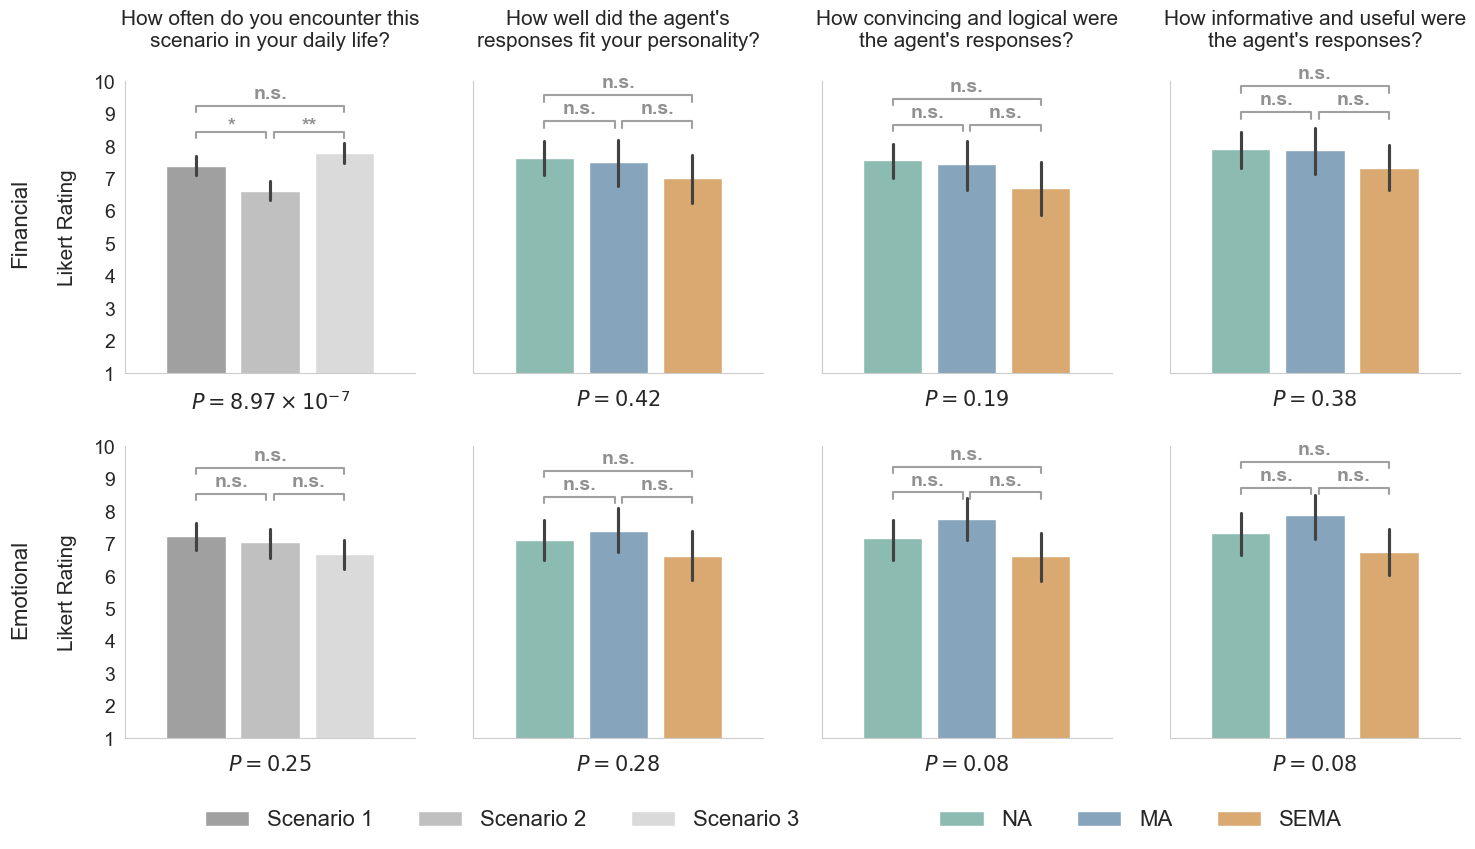

In [15]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 9), sharey=True)

font_size_title = 15
font_size_text = 14


scenario_order = ["Scenario 1", "Scenario 2", "Scenario 3"]
aspect_desc = {
    "TaskCommonality": "How often do you encounter this scenario in your daily life?",
    "personalization": "How well did the agent's responses fit your personality?",
    "convincing": "How convincing and logical were the agent's responses?",
    "informativeness": "How informative and useful were the agent's responses?",
}

for i, task in enumerate(["Financial", "Emotional"]):
    dft = df[df["task_group"] == task]
    df_common = dft.melt(
        id_vars=["agent_group"],
        value_vars=task_aspects,
        var_name="Scenario",
        value_name="Commonality",
    )
    df_common["Scenario"] = df_common["Scenario"].apply(
        lambda x: f"Scenario {x.replace('task_', '').replace('_commonality', '')}"
    )
    df_scores = dft.melt(
        id_vars=["agent_group"],
        value_vars=agent_aspects,
        var_name="Aspect",
        value_name="Score",
    )
    for j, aspect in enumerate(
        ["TaskCommonality", "personalization", "convincing", "informativeness"]
    ):
        if j == 0:
            sns.barplot(
                data=df_common,
                x="Scenario",
                y="Commonality",
                palette=["#A0A0A0", "#C0C0C0", "#DADADA"],
                hue="Scenario",
                ax=axs[i][j],
                errorbar=("ci", 95),
                legend=True,
            )
            anova_res, post_hoc_res = uf.calc_anova_one_way(
                df_common, "Commonality", "Scenario", "ANOVA"
            )
            # post_hoc_res = post_hoc_res.reindex([0, 2, 1])

        else:
            df_aspect = df_scores[df_scores["Aspect"] == aspect]
            sns.barplot(
                data=df_aspect,
                x="agent_group",
                y="Score",
                hue="agent_group",
                order=agents,
                hue_order=agents,
                palette=palette[:3],
                errorbar=("ci", 95),
                ax=axs[i][j],
                legend=True,
            )
            anova_res, post_hoc_res = uf.calc_anova_one_way(
                df_scores[df_scores["Aspect"] == aspect], "Score", "agent_group", "ANOVA"
            )

        if j:
            y_offset = df_aspect["Score"].mean() + df_aspect["Score"].std() * 0.5 + 0.1
        else:
            y_offset = (
                df_common["Commonality"].mean()
                + df_common["Commonality"].std() * 0.5
                + 0.1
            )
        h = 0.2

        ph_res = "p-tukey" 

        p_val_texts = [uf.get_p_stars(row[ph_res]) for _, row in post_hoc_res.iterrows()]
        p_dict = uf.adjust_pval_text(p_val_texts)
        # print(p_dict)
        for idx, row in post_hoc_res.iterrows():
            agent_1, agent_2, p_val = row["A"], row["B"], row["p-tukey"]
            # if p_val < 0.05:
            if True:
                x1 = agents.index(agent_1) if j else scenario_order.index(agent_1)
                x2 = agents.index(agent_2) if j else scenario_order.index(agent_2)

                y = y_offset + 0.8 * (abs(x1 - x2) - 1)

                x1, x2 = sorted([x1, x2])

                if x1 == 1:
                    x1 += 0.05
                elif x2 == 1:
                    x2 -= 0.05

                axs[i][j].plot(
                    [x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color="#A0A0A0"
                )
                p_val_text = p_dict[p_val_texts[idx]]

                h_offset = 0.1 if p_val_text == "n.s." else -0.1
                axs[i][j].text(
                    (x1 + x2) * 0.5,
                    y + h + h_offset,
                    p_val_text,
                    ha="center",
                    va="bottom",
                    color="#909090",
                    fontweight="bold",
                    fontsize=font_size_text,
                )

        anova_pval = anova_res["p-unc"]
        p_stars = uf.get_p_stars(anova_pval)
        p_stars = p_dict[p_stars]
        anova_text = uf.pretty_pval(anova_pval)
        axs[i][j].set_xlabel(
            f"$P = {anova_text}$",
            fontsize=font_size_text + 1,
            labelpad=12,
            style="italic",
        )

        axs[i][j].set_xticks([])
        axs[i][j].legend([], [], frameon=False)
        # axs[i][j].grid(axis="y", linetyle=":", linewidth=0.8,visible=False)
        axs[i][j].set_yticks([i for i in range(1, 11)])
        axs[i][j].grid(axis="y", visible=False)
        axs[i][j].set_ylabel("")
        axs[i][j].margins(0.2)
        axs[0][j].set_title(
            "\n".join(wrap(aspect_desc[aspect], 32)), fontsize=font_size_title, pad=25
        )
        axs[i][0].set_ylabel("Likert Rating", fontsize=font_size_title, labelpad=12)
        axs[i][j].set_ylim([1, 10])
        axs[i][j].spines["top"].set_visible(False)
        axs[i][j].spines["right"].set_visible(False)
        axs[i][j].tick_params(axis="y", which="major", labelsize=14)
        # axs[1][j].set_xlabel("", fontsize=12, labelpad=6)


axs[1][0].legend(
    loc="center",
    fontsize=font_size_title + 1,
    bbox_to_anchor=(1.3, -0.28),
    ncols=3,
    frameon=False,
)
handles, _ = axs[1][2].get_legend_handles_labels()
annot = ["NA", "MA", "SEMA"]
handle_with_annot = [f"{a} ({b})" for a, b in zip(agents, annot)]
axs[1][2].legend(
    handles,
    annot,
    loc="center",
    fontsize=font_size_title + 1,
    bbox_to_anchor=(1.1,-0.28),
    ncols=3,
    frameon=False,
)

plt.subplots_adjust(left=0.08, wspace=0.2, hspace=0.25, bottom=0.15, right=0.97)
# fig.tight_layout()

x = 0.01
y = 0.7
fig.text(x, y - 0.022, "Financial", ha="center", fontsize=16, rotation=90)
fig.text(x, y - 0.435, "Emotional", ha="center", fontsize=16, rotation=90)

plt.show()
fig.savefig("../figures/user_feedback.pdf", dpi=300)

### Comments

In [16]:
df["is_helpful"] = df["helpfulness_keywords"].apply(
    lambda x: 0 if "unhelpful" in x else 1
)
df.groupby(["task_group", "agent_group"], observed=True)[["is_helpful"]].mean()

is_helpful
task_group agent_group            
Financial  Neutral        0.975000
           MA             0.868421
           SEMA           0.789474
Emotional  Neutral        0.871795
           MA             0.864865
           SEMA           0.756098

In [17]:
df.groupby(["task_group", "agent_group"], observed=True)[["ai_influence_detect"]].mean()

ai_influence_detect
task_group agent_group                     
Financial  Neutral                 0.000000
           MA                      0.131579
           SEMA                    0.289474
Emotional  Neutral                 0.025641
           MA                      0.081081
           SEMA                    0.097561

In [18]:
z_tests = []
for task in ["Financial", "Emotional"]:
    z_stats = []
    dft = df[df["task_group"] == task]
    c_t = pd.crosstab(dft['agent_group'], dft['is_helpful'])
    chi2, p, dof, expected = chi2_contingency(c_t)
    print(f"{task} => $X^2({dof}) = {chi2:.2f}$, $P= {uf.pretty_pval(p)}$")

    for i in range(len(agents)):
        for j in range(i + 1, len(agents)):
            counts = [c_t.iloc[i][1], c_t.iloc[j][1]]
            totals = [c_t.iloc[i].sum(), c_t.iloc[j].sum()]
            
            # Z-test for proportions
            z, p = proportions_ztest(counts, totals)
            # Cohen's h
            p1 = counts[0] / totals[0]
            p2 = counts[1] / totals[1]
            h = np.abs(2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2))))
            z_stats.append(
                {
                    "domain": task,
                    "group1": f"{agents[i]} ({p1*100:.1f}\%)",
                    "group2": f"{agents[j]} ({p2*100:.1f}\%)",
                    "z": f"{np.abs(z):.2f}",
                    "p": p,
                    "h": f"{h:.2f}",
                }
            )

    p_vals = [z_test["p"] for z_test in z_stats]
    corrected_p = multipletests(p_vals, method="bonferroni")[1]
    for i, z in enumerate(z_stats):
        z["p_new"] = corrected_p[i]
        z["p_val"] = uf.pretty_pval(corrected_p[i])

    z_tests += z_stats


z_tests = pd.DataFrame(z_tests)
print(tabulate(z_tests, headers="keys", tablefmt="pretty"))


Financial => $X^2(2) = 6.38$, $P= 4.11\times 10^{-2}$
Emotional => $X^2(2) = 2.38$, $P= 0.30$
+---+-----------+------------------+---------------+------+----------------------+------+----------------------+-------+
|   |  domain   |      group1      |    group2     |  z   |          p           |  h   |        p_new         | p_val |
+---+-----------+------------------+---------------+------+----------------------+------+----------------------+-------+
| 0 | Financial | Neutral (97.5\%) |  MA (86.8\%)  | 1.77 | 0.07745866076931791  | 0.42 | 0.23237598230795375  | 0.23  |
| 1 | Financial | Neutral (97.5\%) | SEMA (78.9\%) | 2.56 | 0.010363064086690982 | 0.64 | 0.031089192260072947 | 0.03  |
| 2 | Financial |   MA (86.8\%)    | SEMA (78.9\%) | 0.91 | 0.36078330210627474  | 0.21 |         1.0          | 1.00  |
| 3 | Emotional | Neutral (87.2\%) |  MA (86.5\%)  | 0.09 |  0.9288189452079744  | 0.02 |         1.0          | 1.00  |
| 4 | Emotional | Neutral (87.2\%) | SEMA (75.6\%) | 1.33 |

<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:24: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:24: SyntaxWarning: invalid escape sequence '\%'
/var/folders/_m/blpl95d53ns5nqzldymg2s940000gn/T/ipykernel_80175/2672240458.py:23: SyntaxWarning: invalid escape sequence '\%'
  "group1": f"{agents[i]} ({p1*100:.1f}\%)",
/var/folders/_m/blpl95d53ns5nqzldymg2s940000gn/T/ipykernel_80175/2672240458.py:24: SyntaxWarning: invalid escape sequence '\%'
  "group2": f"{agents[j]} ({p2*100:.1f}\%)",


In [19]:
import scipy.stats as stats
for task in ["Financial", "Emotional"]:
    dft = df[df["task_group"] == task]
    for aspect in ["is_helpful", "ai_influence_detect"]:
        z_tests = []
        c_t = pd.crosstab(dft['agent_group'], dft[aspect])
        chi2, p, dof, expected = chi2_contingency(c_t)
        print(f"{task} - {aspect} => $X^2({dof}) = {chi2:.2f}$, $P= {uf.pretty_pval(p)}$")
        alpha = 0.05
        num_comparisons = len(agents)
        corrected_alpha = alpha / num_comparisons


        print(f"Z-test with {num_comparisons} comparisons, confidence = {100*(1 - corrected_alpha):.2f}")
        z_stats = []
        for i in range(len(agents)):
            for j in range(i + 1, len(agents)):
                counts = [c_t.iloc[i][1], c_t.iloc[j][1]]
                totals = [c_t.iloc[i].sum(), c_t.iloc[j].sum()]
                
                # Z-test for proportions
                z, p = proportions_ztest(counts, totals)
                # Cohen's h
                p1 = counts[0] / totals[0]
                p2 = counts[1] / totals[1]
                h = np.abs(2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2))))

                # Confidence intervals
                se = np.sqrt((p1 * (1 - p1) / totals[0]) + (p2 * (1 - p2) / totals[1]))
                diff = p1 - p2
                critical_val = stats.norm.ppf(1 - corrected_alpha / 2)
                ci_lower = diff - critical_val * se
                ci_upper = diff + critical_val * se

                effect_ci_lower = h - critical_val * se
                effect_ci_upper = h + critical_val * se

                z_stats.append(
                    {
                        "domain": task,
                        "group1": f"{agents[i]} ({p1*100:.1f}%)",
                        "group2": f"{agents[j]} ({p2*100:.1f}%)",
                        "ci": f"[{ci_lower*100:.1f}%, {ci_upper*100:.1f}%]",
                        "z": f"{np.abs(z):.2f}",
                        "p": p,
                        "h": f"{h:.2f}",
                        "effect_ci": f"[{effect_ci_lower:.2f}, {effect_ci_upper:.2f}]",
                    }
                )

        p_vals = [z_test["p"] for z_test in z_stats]
        corrected_p = multipletests(p_vals, method="bonferroni")[1]
        for i, z in enumerate(z_stats):
            z["p_new"] = corrected_p[i]
            z["p_val"] = uf.pretty_pval(corrected_p[i])

        z_tests += z_stats


        z_tests = pd.DataFrame(z_tests)
        print(tabulate(z_tests, headers="keys", tablefmt="pretty"))


Financial - is_helpful => $X^2(2) = 6.38$, $P= 4.11\times 10^{-2}$
Z-test with 3 comparisons, confidence = 98.33
+---+-----------+-----------------+--------------+-----------------+------+----------------------+------+--------------+----------------------+-------+
|   |  domain   |     group1      |    group2    |       ci        |  z   |          p           |  h   |  effect_ci   |        p_new         | p_val |
+---+-----------+-----------------+--------------+-----------------+------+----------------------+------+--------------+----------------------+-------+
| 0 | Financial | Neutral (97.5%) |  MA (86.8%)  | [-3.7%, 25.1%]  | 1.77 | 0.07745866076931791  | 0.42 | [0.28, 0.57] | 0.23237598230795375  | 0.23  |
| 1 | Financial | Neutral (97.5%) | SEMA (78.9%) |  [1.7%, 35.5%]  | 2.56 | 0.010363064086690982 | 0.64 | [0.47, 0.80] | 0.031089192260072947 | 0.03  |
| 2 | Financial |   MA (86.8%)    | SEMA (78.9%) | [-12.7%, 28.5%] | 0.91 | 0.36078330210627474  | 0.21 | [0.01, 0.42] |       